In [13]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )


#### Step 1: Load and Prepare Data 

In [3]:
# loading & preparing gdp data
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']].loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']]
gdp_df   = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_isos  = gdp_df.iso.unique()

# loading and preparing tas_baseline
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[(tas_df.year == 2015) & (~tas_df['run'].str.contains('Ref_1p5'))].copy()
tas_df = tas_df.loc[tas_df.iso.isin(gdp_isos),:].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Refv2'), 'scen_run'] = tas_df['scen_run'].str.replace('Refv2', 'Ref')

# loading & preparing glmt data 
thrshld = 1.35
glmt_char_df = pd.read_csv(cset.path_MESMER_char / 'gmt_characteristics_thsld_135.csv', index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df['tas_soc']      -= regression_df['tas_baseline']
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']       = regression_df['gmt_max']- regression_df['gmt_eoc']
regression_df['log_gmt_cum']  = np.log(regression_df['gmt_cum'])
regression_df['gmt_delta_max'] = regression_df['gmt_max'] - regression_df['gmt_eoc']

In [5]:
# better target variable compared to regression_df['diff_SSP2']
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = ['tas_soc', 'tas_baseline', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_exc']
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')) | ('gmt_eoc' in f)]
# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])
# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

#### Step 2: fit RF for each country seperately 

##### a: Exploring all predictors 

In [46]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 
                  'gmt_eoc', 'tas_baseline gmt_eoc', 
                  'gmt_exc', 'tas_baseline gmt_exc',
                  'gmt_max', 'tas_baseline gmt_max', 
                  'gmt_cum', 'tas_baseline gmt_cum'
                  ]
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

country_data = regression_df[regression_df.tas_baseline >= 0].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 0, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[regression_df.tas_baseline >= 0][country_data.run < 70,:].copy()
X_intercept_test = X_intercept[regression_df.tas_baseline >= 0][country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9403062970425224 Test score:  0.9342378619940286


In [47]:
rf = RandomForestRegressor(n_estimators = 500, 
                            bootstrap = True,
                            random_state=42, 
                            max_depth = 10, 
                            min_samples_leaf = 3,
                            min_samples_split = 5,
                            max_features = 'auto')
rf.fit(np.c_[X_train, X_intercept_train], 
       y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=500, random_state=42)

In [48]:
rf.score(np.c_[X_train, X_intercept_train], y_train), rf.score(np.c_[X_test, X_intercept_test], y_test)

(0.9411492351589632, 0.9192831353385125)

In [ ]:
['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_exc', 'tas_baseline gmt_exc', 'gmt_max', 'tas_baseline gmt_max', 'gmt_cum', 'tas_baseline gmt_cum']

In [ ]:
'tas_baseline gmt_max'
'tas_baseline gmt_cum'
'tas_soc tas_baseline'
'tas_soc'
'gmt_exc'
'gmt_cum'
'gmt_eoc'
'gmt_max'
'tas_baseline gmt_exc'
'tas_baseline gmt_eoc'

In [49]:
rf.feature_importances_.argsort()[::-1]

array([  7,   9,   1,   0,   4,   8,   2,   6,   5,   3, 133, 129, 109,
        13, 104,  89,  78, 117, 113, 135,  32,  79,  22,  94,  33,  57,
       146,  64, 140, 134, 112,  23, 138, 131, 163,  31, 143, 137,  53,
       154, 158,  21, 124,  90,  12,  62, 125,  63,  84,  75, 161, 111,
        48,  55, 145, 148,  77, 114, 147,  34,  24, 128,  87, 136, 162,
       156,  30,  65, 101,  80,  42, 150, 127,  69, 110,  28, 121,  96,
        14, 166, 120,  38, 122,  17, 151,  39,  74,  40,  68,  37,  16,
        98, 119, 105,  26, 149,  11,  41,  45,  70,  83,  44,  50, 130,
       164, 152,  43,  72,  25,  73, 165, 118, 142, 139,  99,  91, 132,
        82, 144,  19,  71,  76, 100,  35,  86, 106, 103,  93,  67,  61,
        27, 115,  56,  49, 157,  92,  20,  59,  88,  52,  18,  97, 102,
        58, 123,  29,  51, 108,  10,  85,  66, 153,  95,  47, 126, 159,
        54, 160,  81, 141,  46,  15, 155,  60,  36, 116, 107])

In [12]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_max', 'tas_baseline gmt_max']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

for sel_predictors in [['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_exc', 'tas_baseline gmt_exc'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum'], 
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_max', 'tas_baseline gmt_max'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc'], 
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_exc', 'tas_baseline gmt_exc'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_max', 'tas_baseline gmt_max'], 
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_exc', 'tas_baseline gmt_exc', 'gmt_max', 'tas_baseline gmt_max'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_exc', 'tas_baseline gmt_exc', 'gmt_cum', 'tas_baseline gmt_cum'],
                       ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_max', 'tas_baseline gmt_max']
                        ]: 
    country_data = regression_df[regression_df.tas_baseline >= 0].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)

    X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 0, sel_predictors].copy()
    X_country     = X_country_raw.values.copy()
    X_train       = X_country[country_data.run < 70,:].copy()
    y_train       = y_country[country_data.run < 70].copy()
    X_test        = X_country[country_data.run >= 70,:].copy()
    y_test        = y_country[country_data.run >= 70].copy()

    X_intercept_train = X_intercept[regression_df.tas_baseline >= 0][country_data.run < 70,:].copy()
    X_intercept_test = X_intercept[regression_df.tas_baseline >= 0][country_data.run >= 70,:].copy()

    linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
    print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9390831888938018 Test score:  0.9333141146012842
Train score:  0.9380603316710825 Test score:  0.9309931709573427
Train score:  0.9272134225992483 Test score:  0.9209963307934598
Train score:  0.9108137547285005 Test score:  0.9058737404060515
Train score:  0.9368435610554092 Test score:  0.9312919004512124
Train score:  0.9267201074311945 Test score:  0.9206091174635472
Train score:  0.9350154335680232 Test score:  0.9276248383980088
Train score:  0.9393645889371157 Test score:  0.9339372848315337
Train score:  0.9382009737977431 Test score:  0.9318280570734051
Train score:  0.9387820495054349 Test score:  0.932198042503115


In [10]:
# select important variable via forward and backward selection
# note: the model selection via BIC is prone to overfitting, 
# that is more and more variables are selected while quality metrics 
# such as R^2 or RMSE do not significantly improve 

# Functions for fitting model
def fit_model_and_calculate_bic(X_, y_):
    model = sm.OLS(endog = y_, exog = X_).fit()
    return model.bic, model.rsquared, model


all_predictors     = list(predictors) + list(interaction_terms)

best_rsquared = 0
threshold_r   = 0
threshold_in  = 700
threshold_out = 700
included      = []
best_bic      = np.inf

included = ['tas_baseline gmt_exc', 'tas_soc tas_baseline', 'tas_soc', 'gmt_exc']

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

-160325.96170843835
['tas_baseline gmt_exc', 'tas_soc tas_baseline', 'tas_soc', 'gmt_exc', 'tas_baseline gmt_eoc', 'tas_baseline gmt_cum']
-161294.21342690988
['tas_baseline gmt_exc', 'tas_soc tas_baseline', 'tas_soc', 'gmt_exc', 'tas_baseline gmt_eoc', 'tas_baseline gmt_cum', 'gmt_cum']
-162052.22821699327
['tas_baseline gmt_exc', 'tas_soc tas_baseline', 'tas_soc', 'gmt_exc', 'tas_baseline gmt_eoc', 'tas_baseline gmt_cum', 'gmt_cum', 'tas_baseline gmt_max']


KeyboardInterrupt: 

In [9]:
(161960-161203)/161203

0.004695942383206268

In [20]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

country_data = regression_df[regression_df.tas_baseline >= 0].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 0, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[regression_df.tas_baseline >= 0][country_data.run < 70,:].copy()
X_intercept_test = X_intercept[regression_df.tas_baseline >= 0][country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9380603316710825 Test score:  0.9309931709573427


In [21]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_exc', 'tas_baseline gmt_exc', 'gmt_max', 'tas_baseline gmt_max']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

country_data = regression_df[regression_df.tas_baseline >= 0].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 0, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[regression_df.tas_baseline >= 0][country_data.run < 70,:].copy()
X_intercept_test = X_intercept[regression_df.tas_baseline >= 0][country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9395013088662224 Test score:  0.9341016444105901


In [32]:
# employ grid search CV for a single RF model: 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

iso = 'IND'

country_data  = regression_df[regression_df['iso'] == iso].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)
X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
X_country     = StandardScaler().fit_transform(X_country_raw)
X_train       = X_country[country_data.run < 70,:]
y_train       = y_country[country_data.run < 70]
X_test        = X_country[country_data.run >= 70,:]
y_test        = y_country[country_data.run >= 70]

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 80, 110],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 5, 10],
    'min_samples_split': [3, 5, 10],
    'n_estimators': [200, 500, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=500; tota

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 200}

In [33]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [34]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


Model Performance
Average Error: 0.1494 degrees.
Accuracy = 75.59%.


In [35]:
evaluate(best_grid, X_train, y_train)

Model Performance
Average Error: 0.0977 degrees.
Accuracy = 97.24%.


97.24271435207477

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


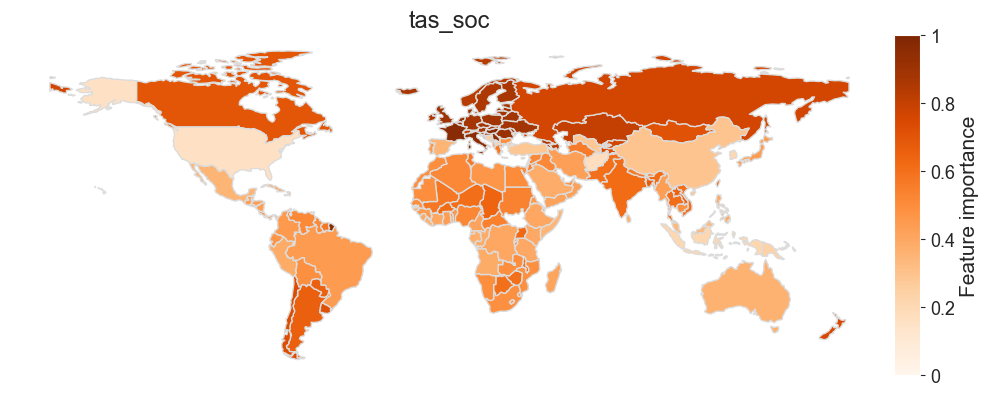

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


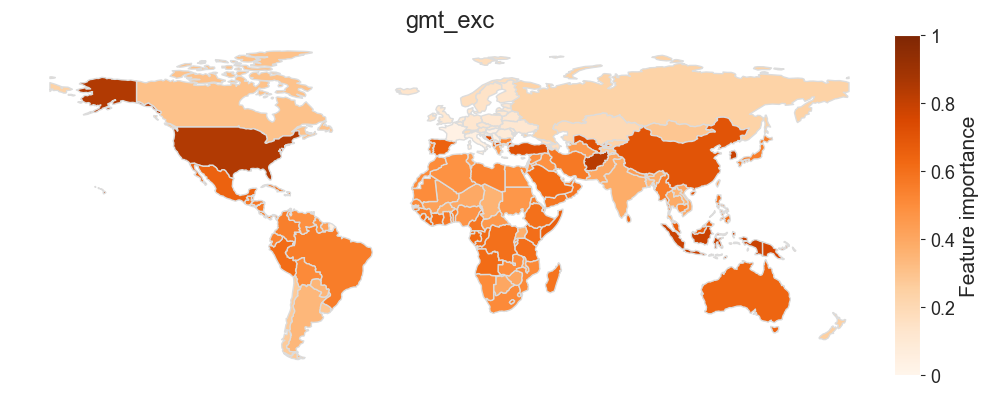

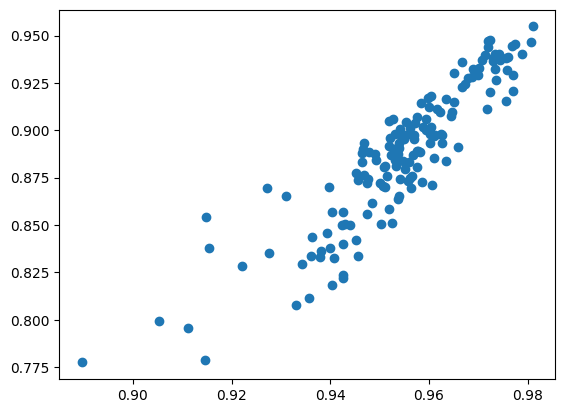

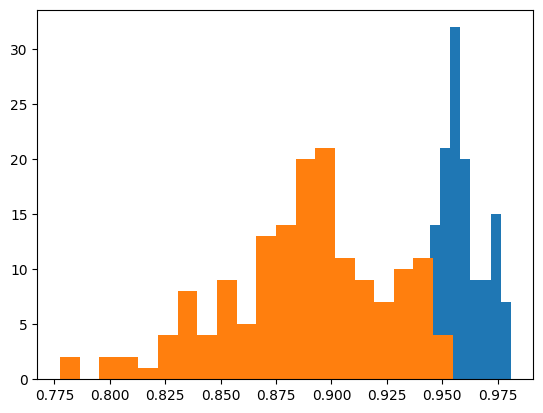

In [37]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_exc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 500, 
                               bootstrap = True,
                               random_state=42, 
                               max_depth = 20, 
                               min_samples_leaf = 3,
                               min_samples_split=5,
                               max_features = 'auto')
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
# plt.plot([0,1], [0,1], color = 'C1')
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


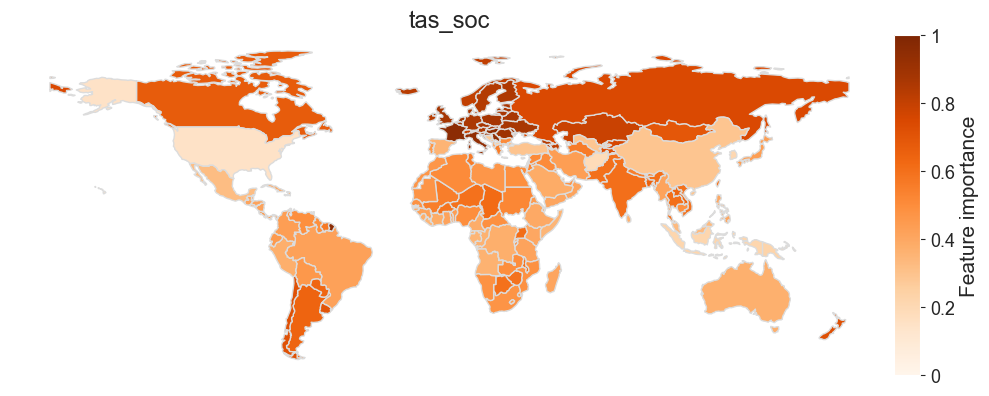

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


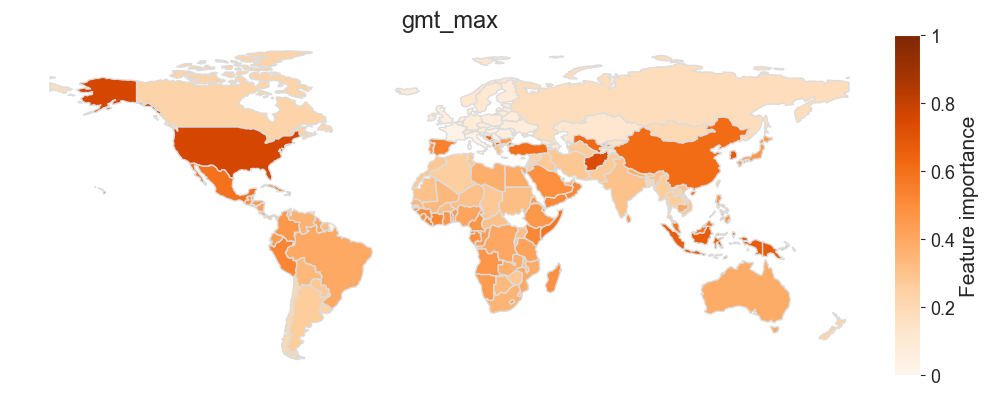

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


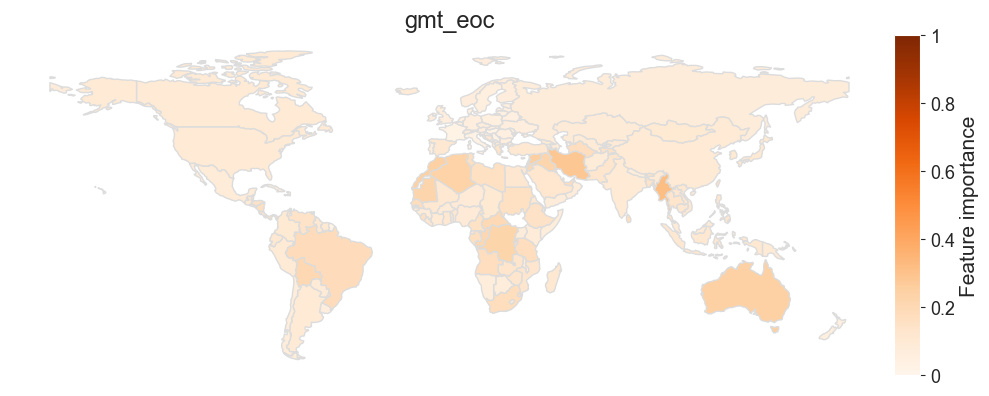

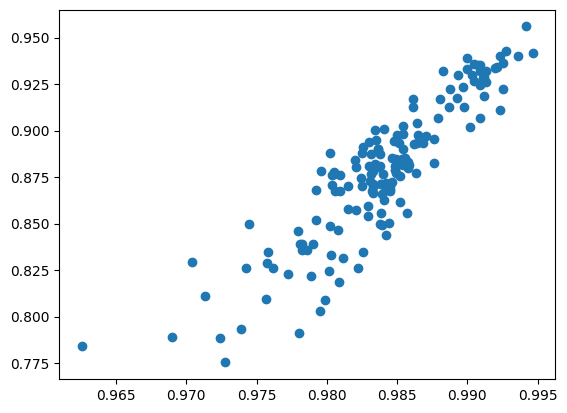

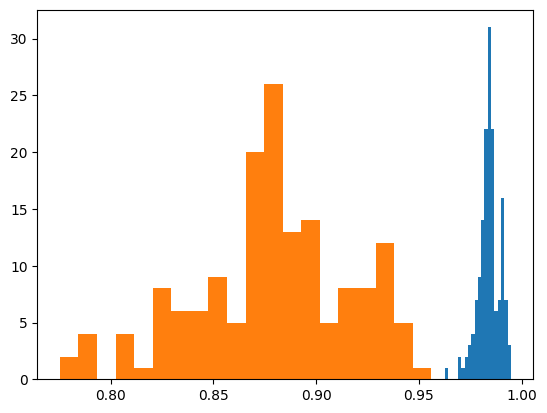

In [15]:
sel_predictors = ['tas_soc', 'gmt_max', 'gmt_eoc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
# plt.plot([0,1], [0,1], color = 'C1')
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


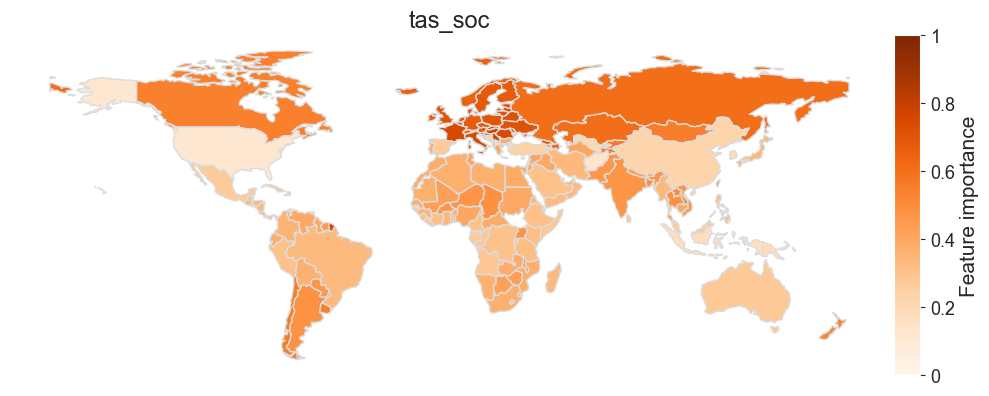

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


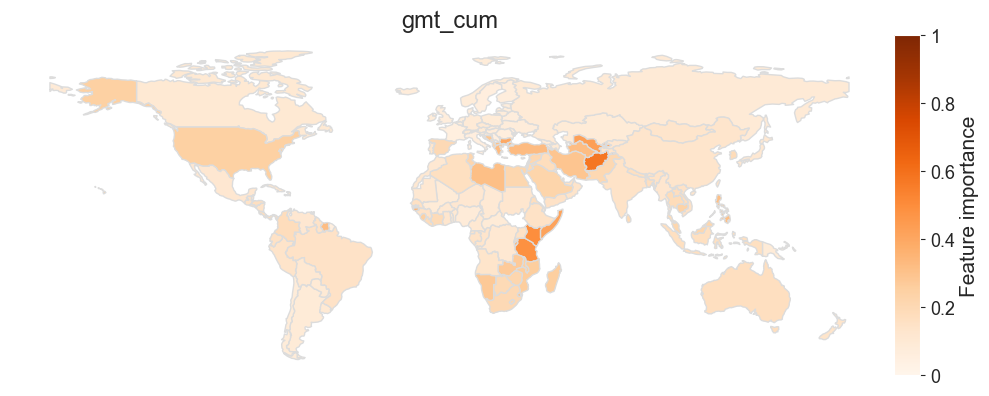

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


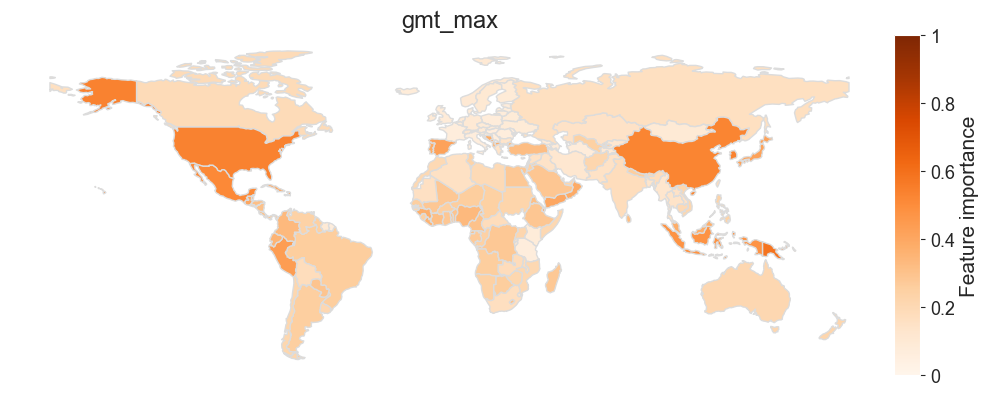

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


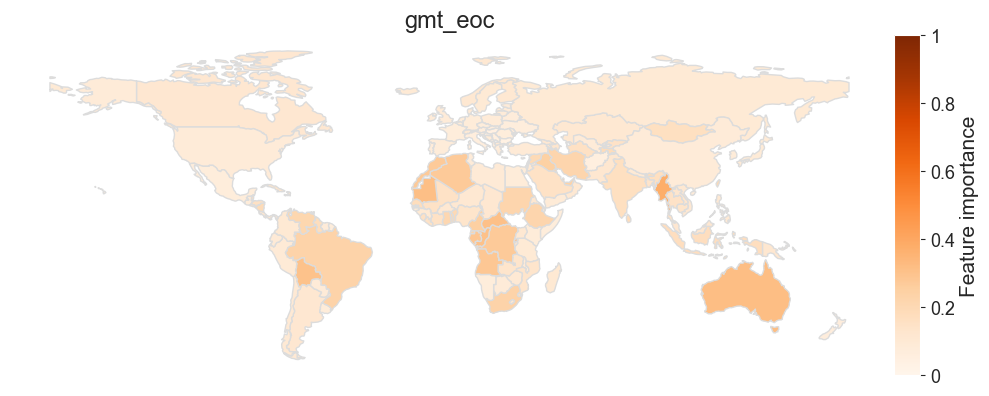

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


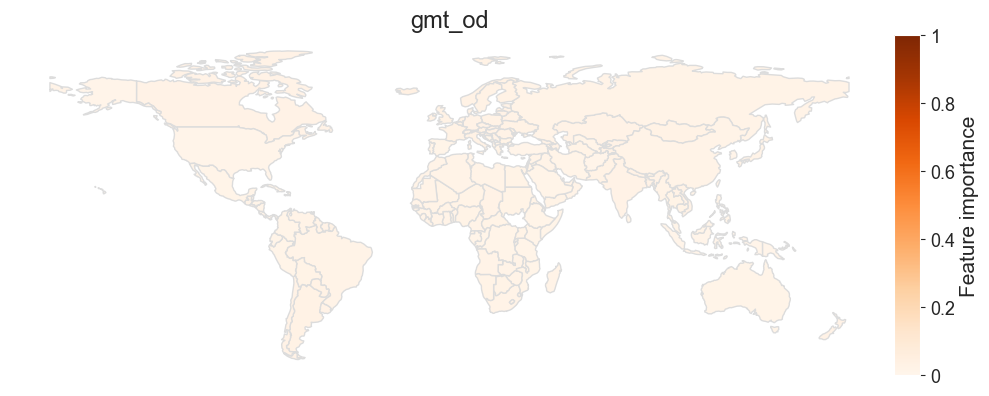

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


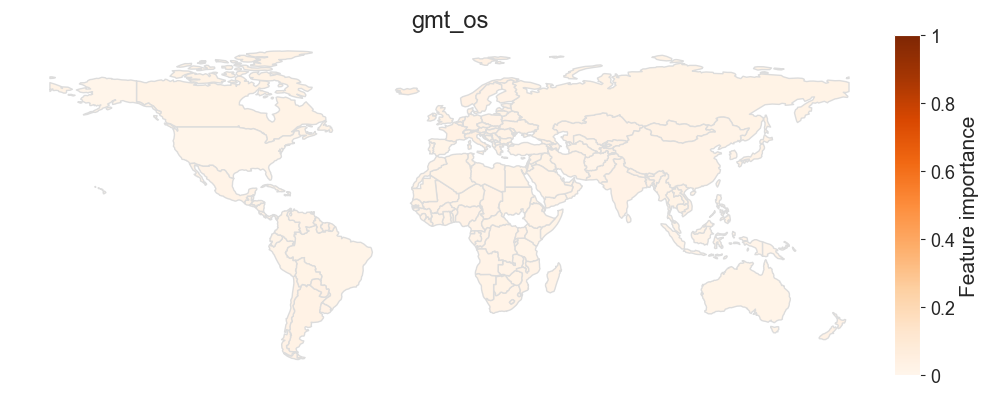

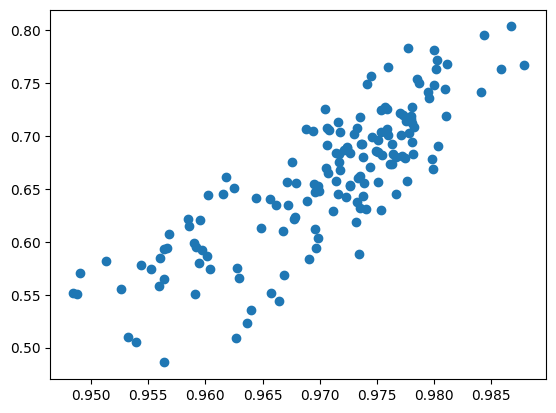

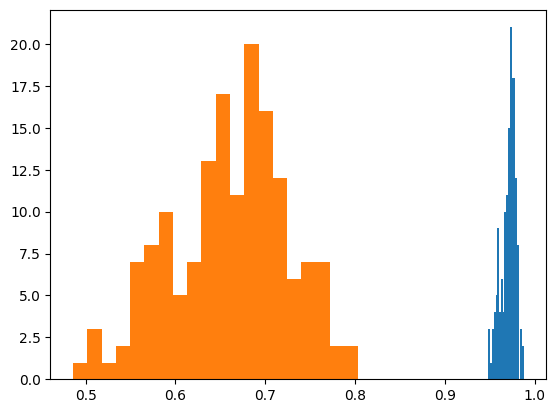

In [19]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_od', 'gmt_os']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
# plt.plot([0,1], [0,1], color = 'C1')
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

#### b: Expploring variations 

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


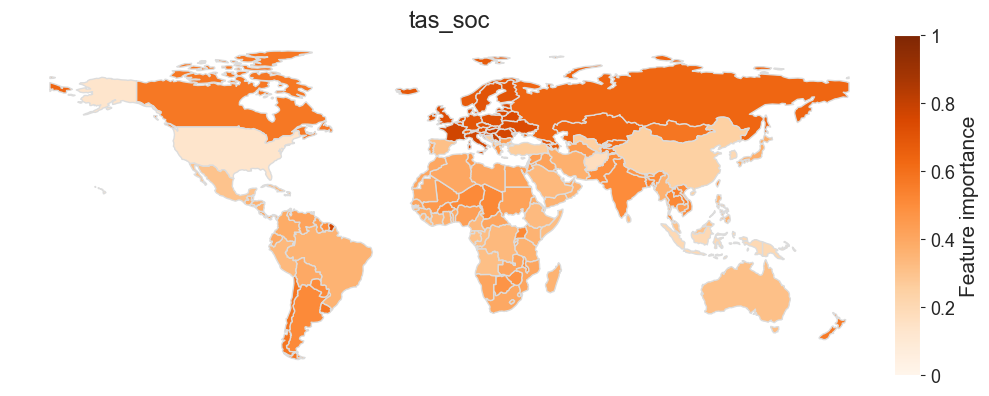

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


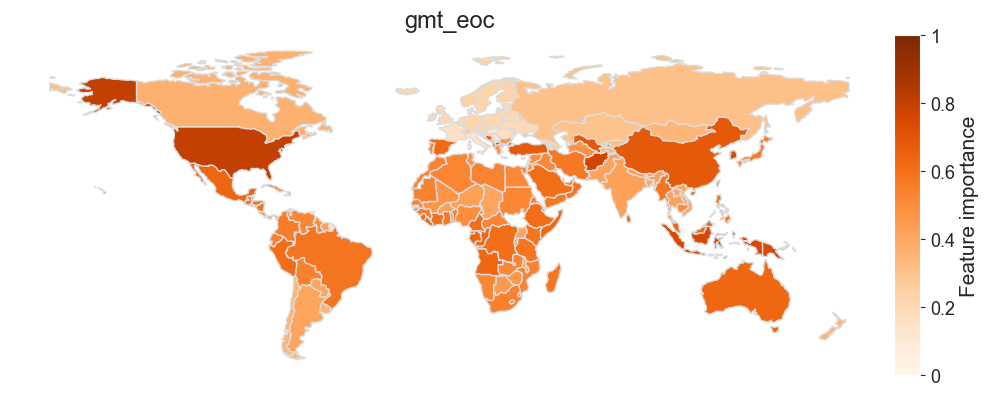

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


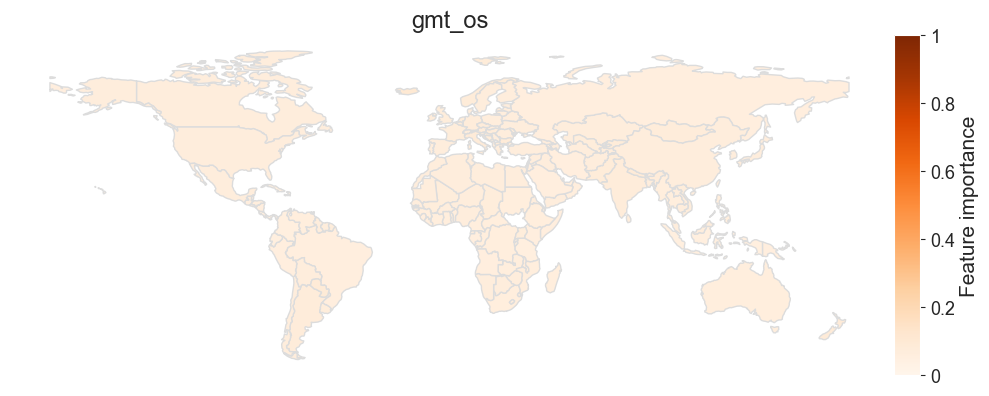

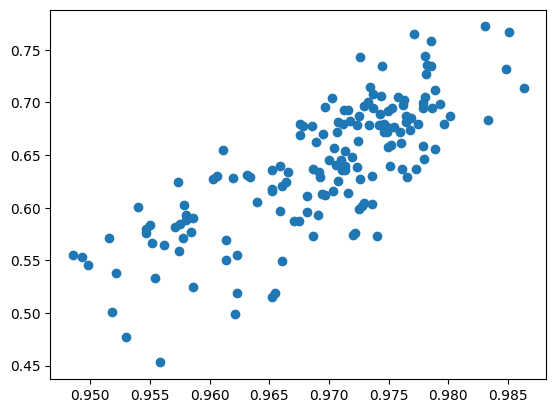

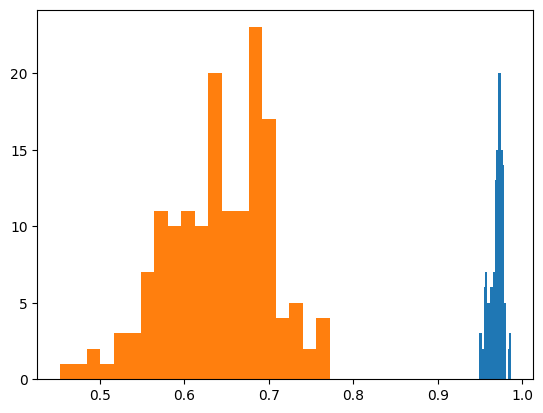

In [21]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_os']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


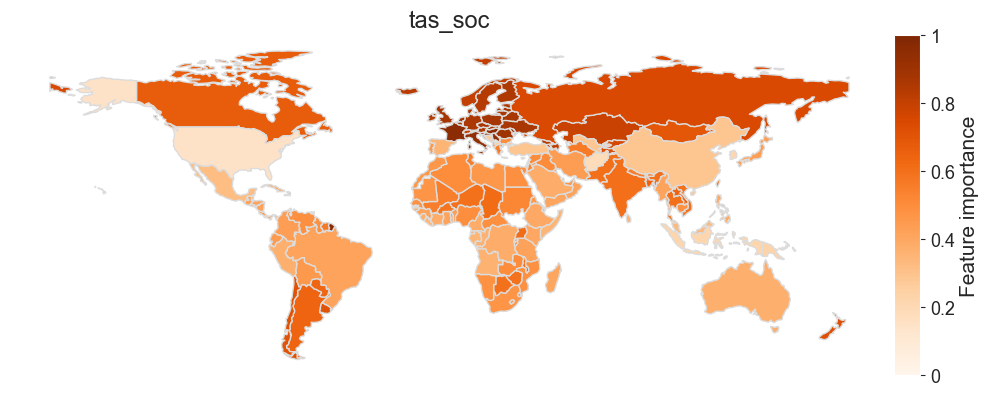

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


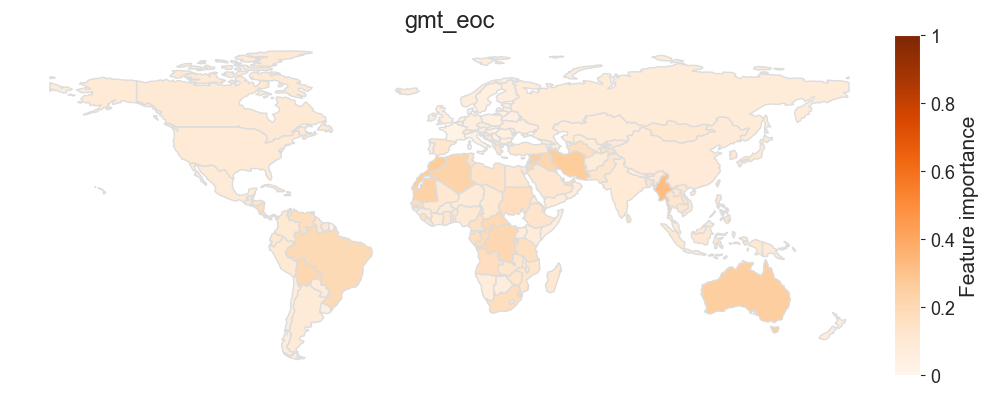

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


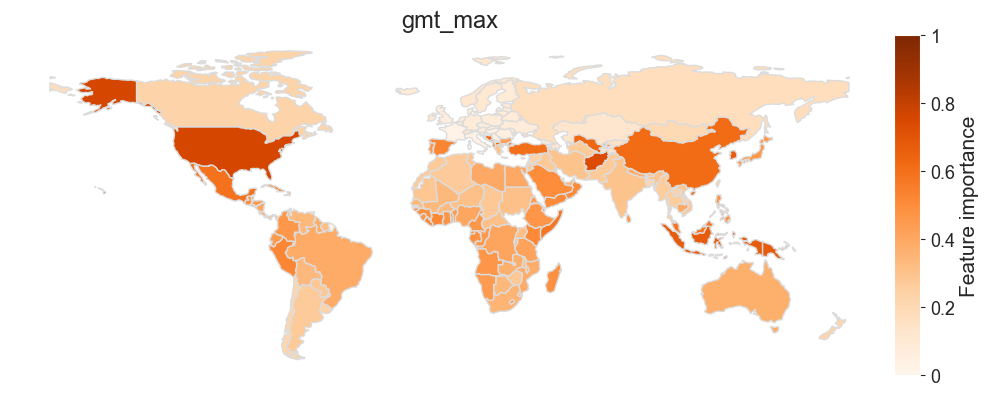

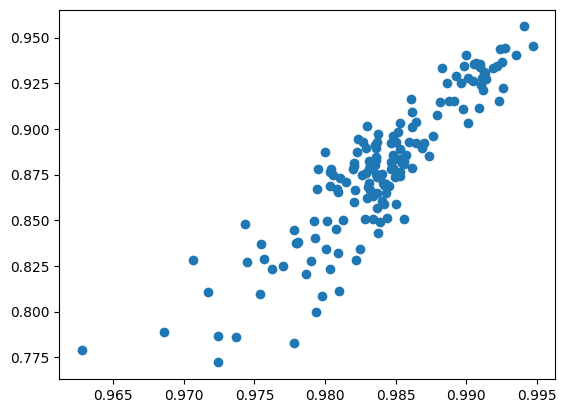

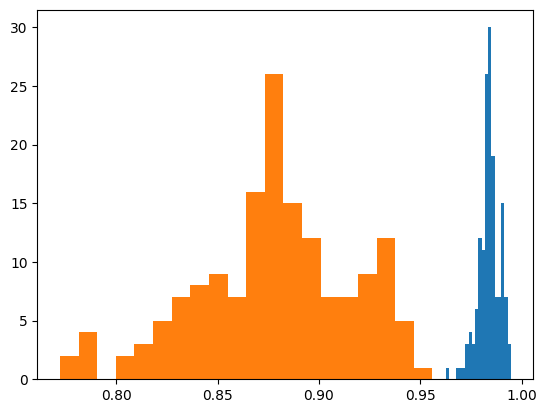

In [22]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


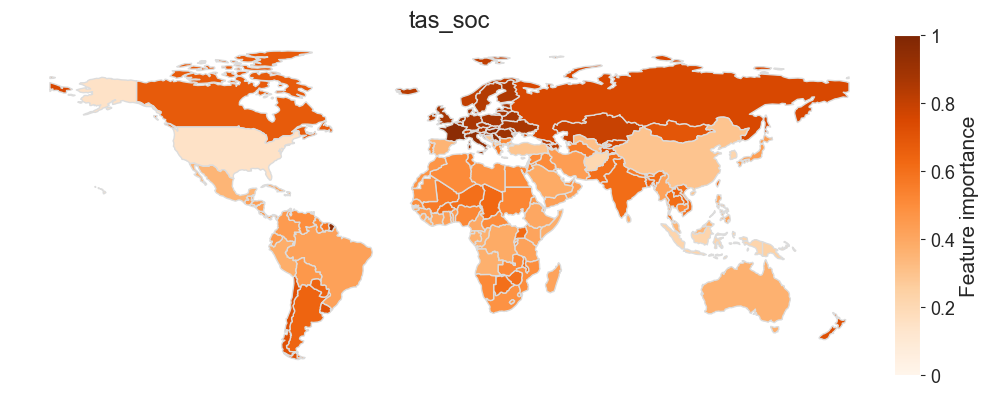

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


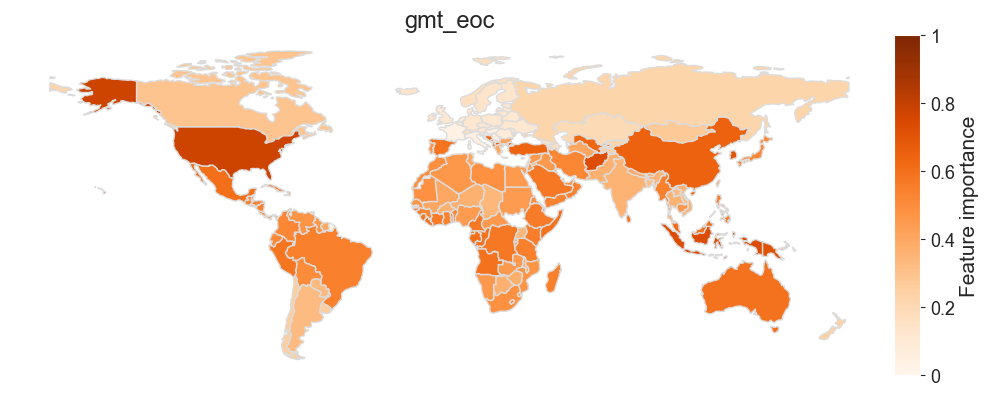

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


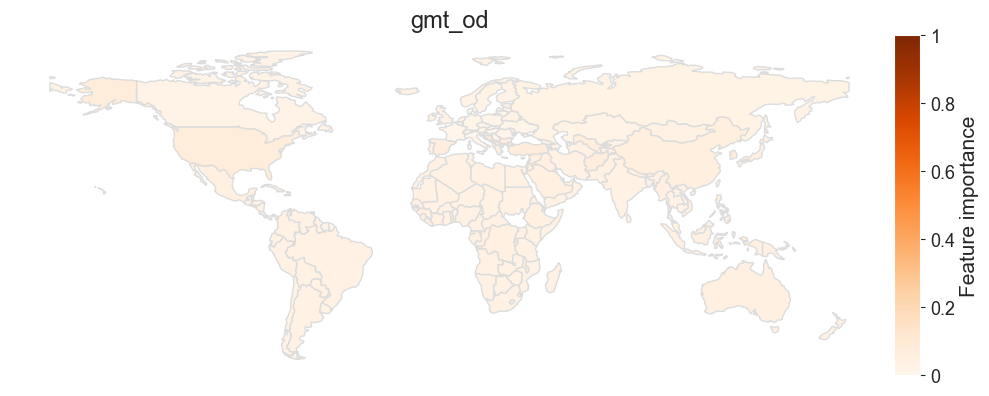

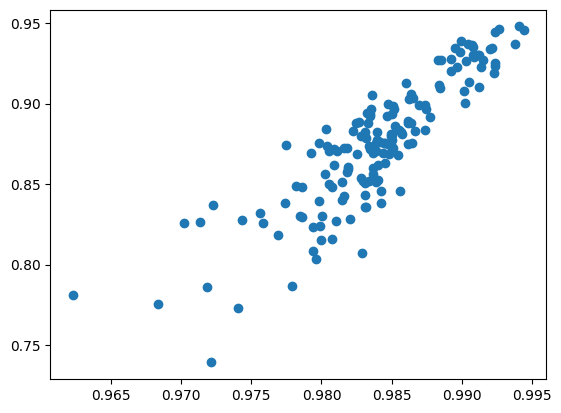

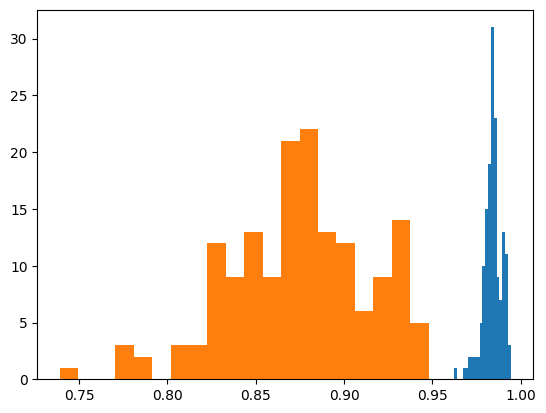

In [20]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_od']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


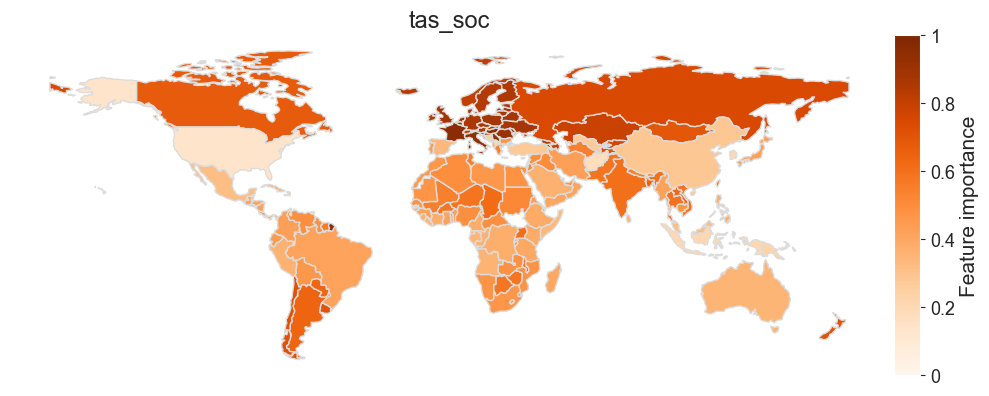

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


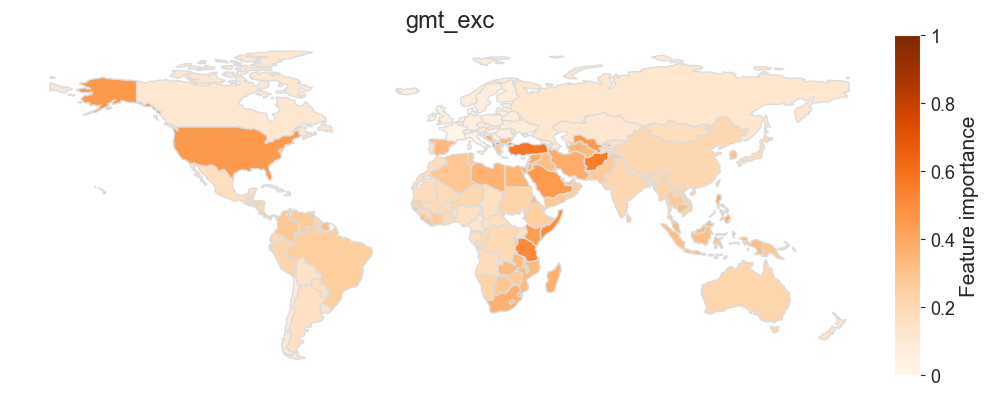

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


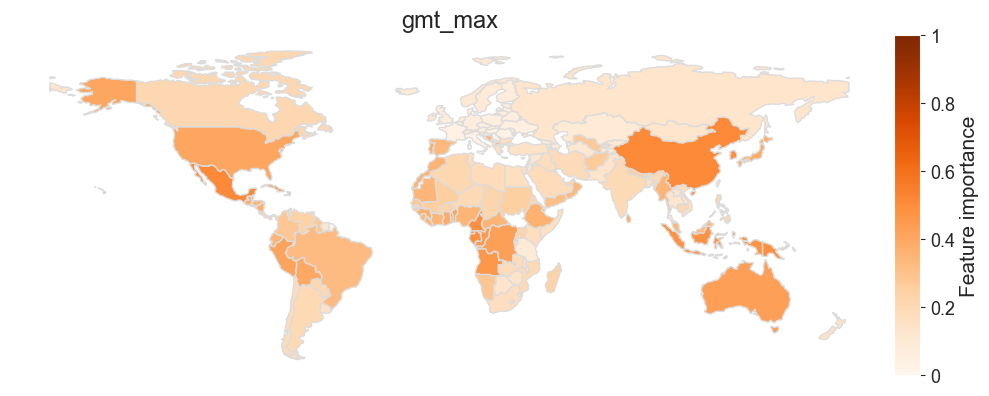

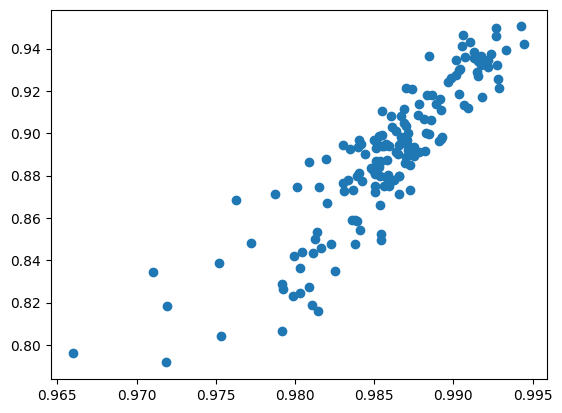

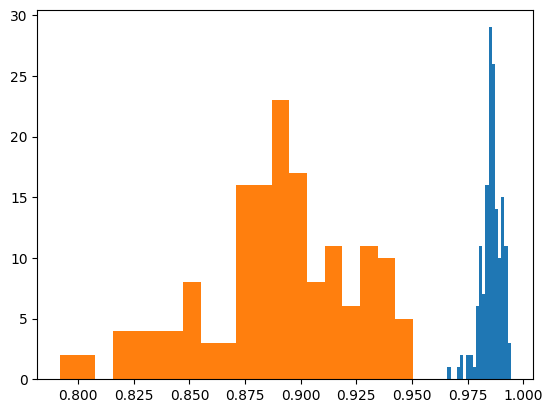

In [29]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


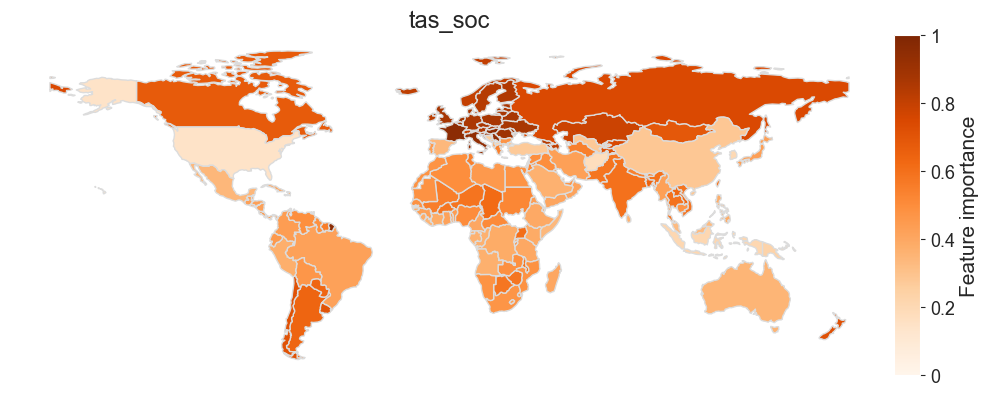

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


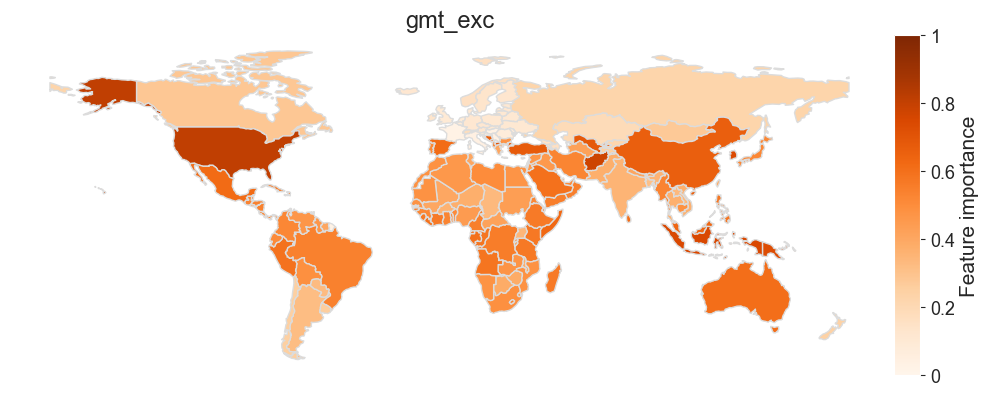

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


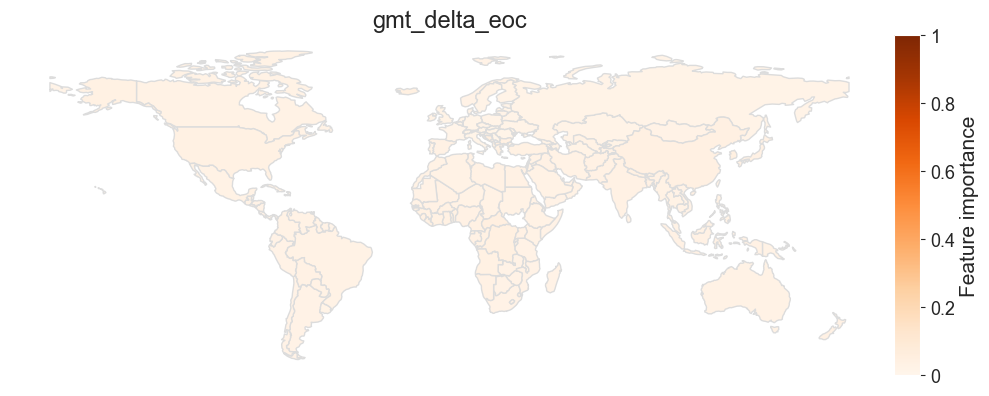

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


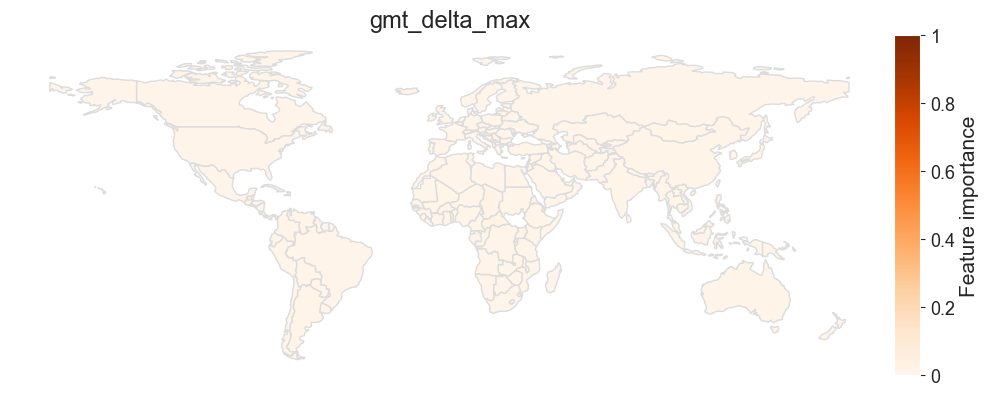

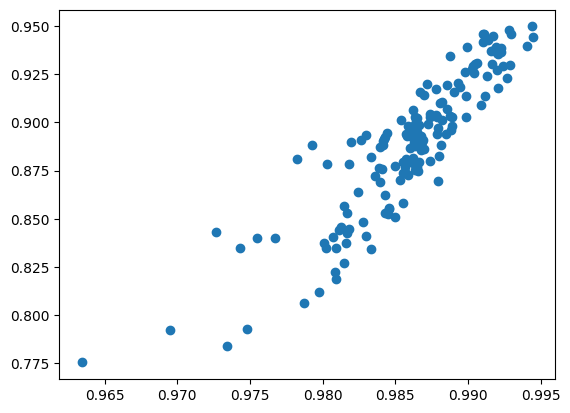

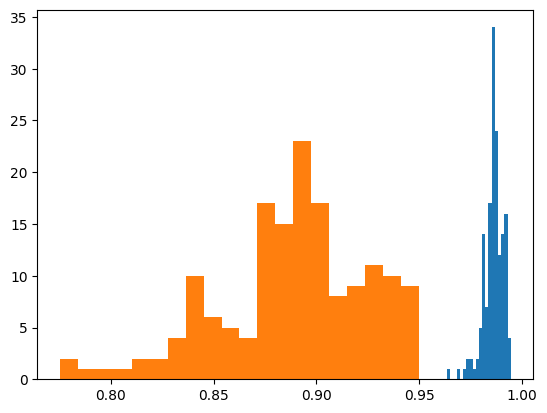

In [58]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


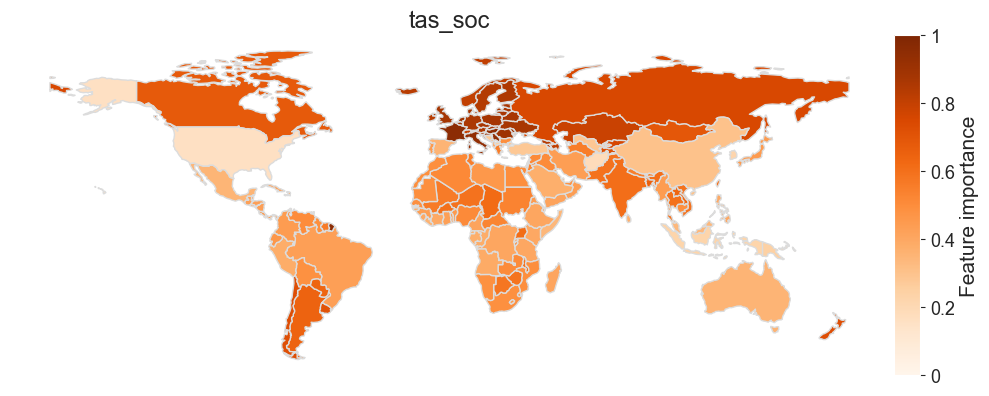

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


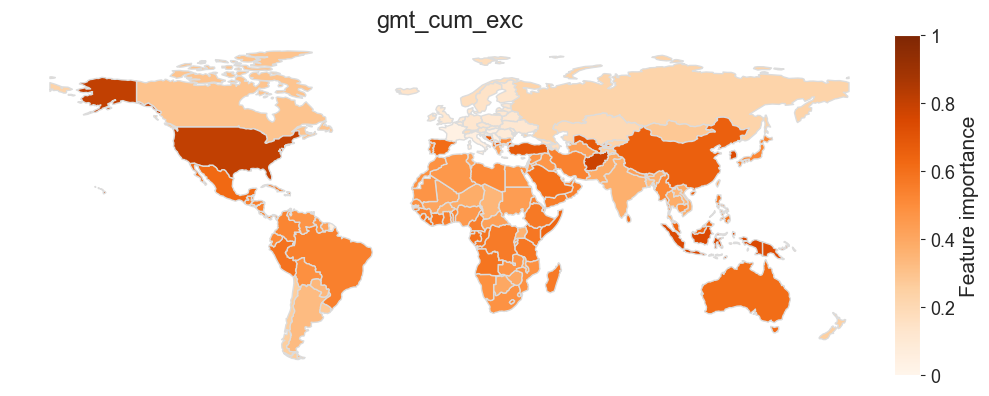

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


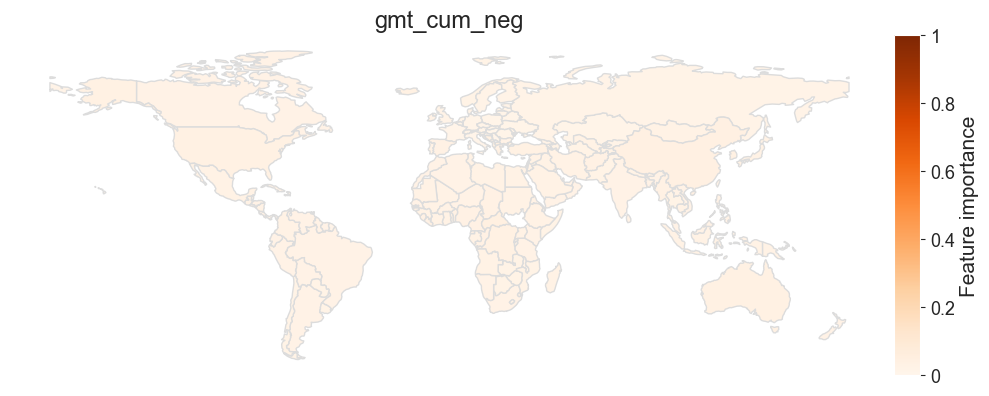

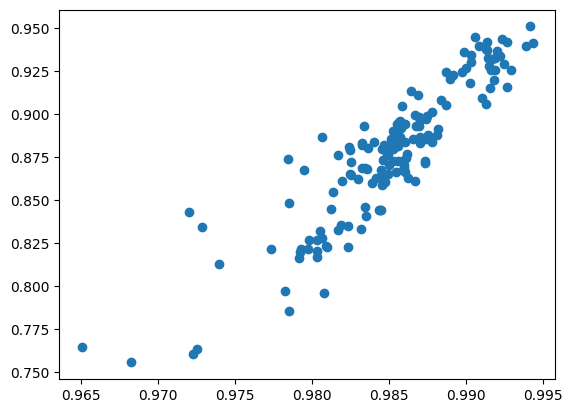

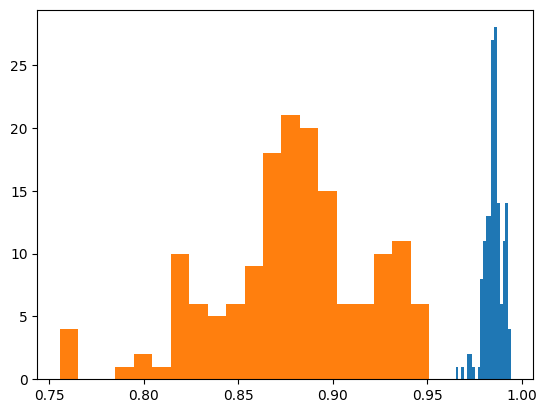

In [7]:
sel_predictors = ['tas_soc', 'gmt_cum_exc', 'gmt_cum_neg']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


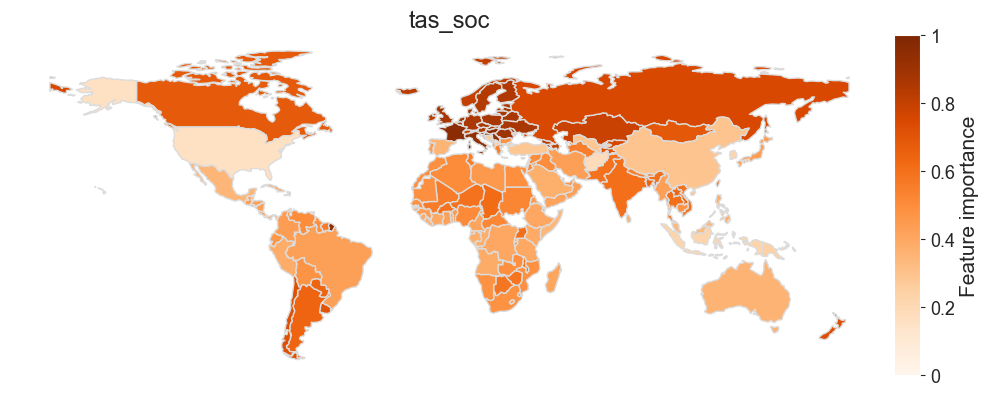

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


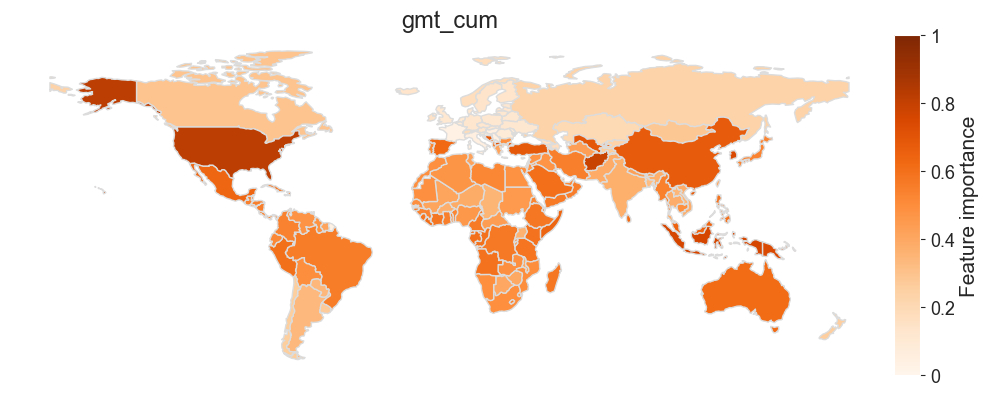

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


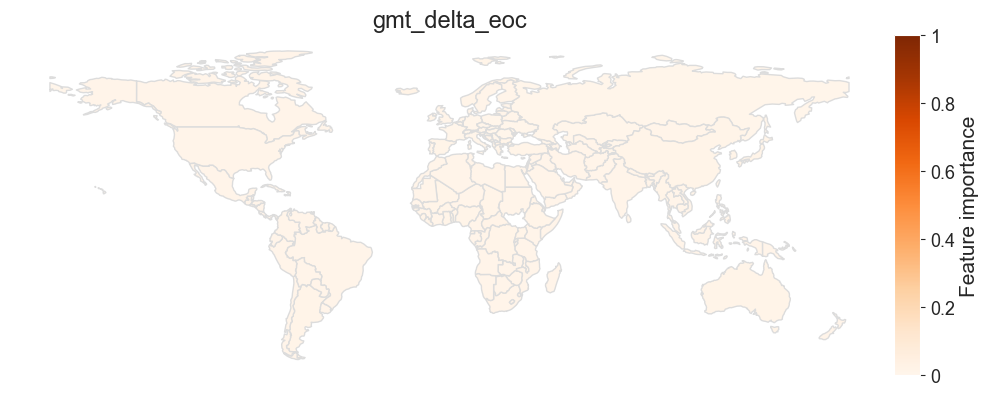

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


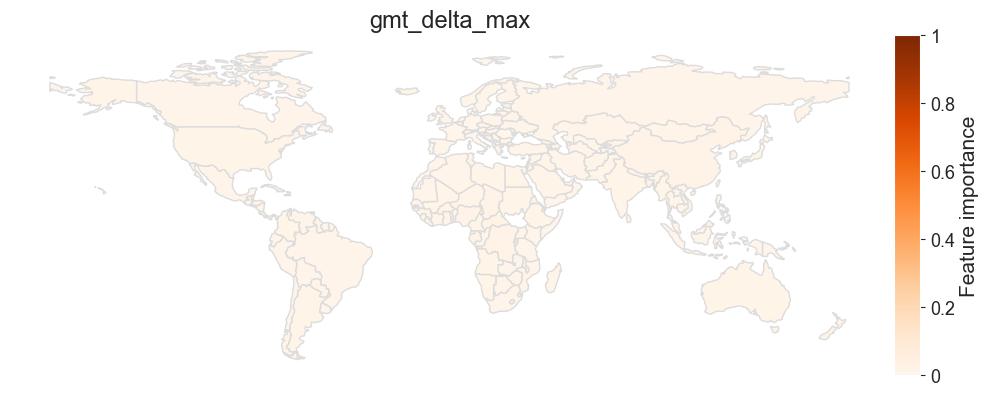

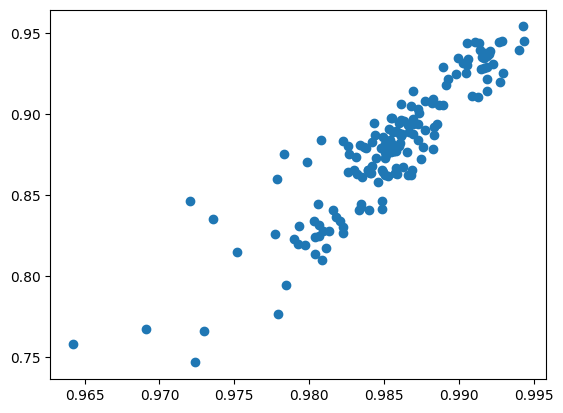

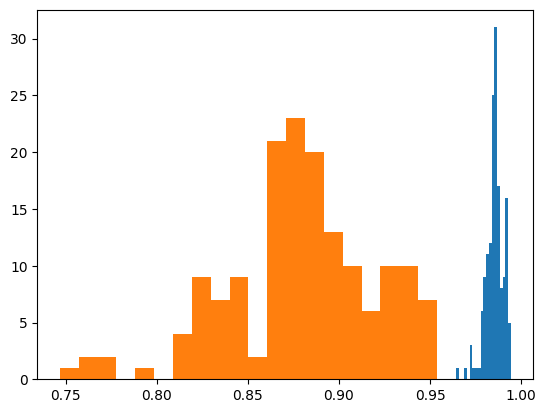

In [22]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_delta_eoc', 'gmt_delta_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

#### c: Hyper-parameter tuning 

#### d: distribution of coefficients across models

In [13]:
predictor_df

tas_soc  tas_baseline   gmt_cum   gmt_max   gmt_eoc    gmt_os  \
0       1.261309     -0.770121  1.322797  1.959981  2.062101 -0.913158   
1       2.537376     -0.770121  0.035834  0.743271  0.903613 -0.913158   
2       1.563342     -0.770121  1.418064  2.135664  2.229378 -0.913158   
3      -0.124967     -0.770121  0.035834  0.743271  0.903613 -0.913158   
4       0.928253     -0.770121  0.302739  1.056668  1.202014 -0.913158   
...          ...           ...       ...       ...       ...       ...   
156995 -0.399567      0.300891  0.535571  0.454149  0.008263  1.977042   
156996 -0.486344      0.300891  0.448301  0.348646 -0.075301  1.898312   
156997  1.568238      0.300891  0.448301  0.348646 -0.075301  1.898312   
156998  0.364299      0.300891  1.718645  1.276856  1.147342  0.318889   
156999  0.164998      0.300891  1.224103  0.919732  0.437492  2.042650   

          gmt_od  gmt_cum_exc  gmt_cum_neg  tas_soc^2  ...  gmt_os^2  \
0      -0.914268     1.246814    -0.960691   0.293608  ... -0.598241   
1      -0.914268    -0.063912    -0.960691   2.702187  ... -0.598241   
2      -0.914268     1.343841    -0.960691   0.717518  ... -0.598241   
3      -0.914268    -0.063912    -0.960691  -0.489123  ... -0.598241   
4      -0.914268     0.207921    -0.960691  -0.068742  ... -0.598241   
...          ...          ...          ...        ...  ...       ...   
156995  1.653381     0.690891     1.391470  -0.417554  ...  2.126758   
156996  1.612552     0.608338     1.452022  -0.379355  ...  1.980321   
156997  1.612552     0.608338     1.452022   0.725136  ...  1.980321   
156998  0.024376     1.730434    -0.190843  -0.430940  ... -0.103059   
156999  1.686623     1.385857     1.331386  -0.483356  ...  2.251878   

        gmt_os gmt_od  gmt_os gmt_cum_exc  gmt_os gmt_cum_neg  gmt_od^2  \
0           -0.629826           -0.781657           -0.672047 -0.654077   
1           -0.629826           -0.781657           -0.672047 -0.654077   
2           -0.629826           -0.781657           -0.672047 -0.654077   
3           -0.629826           -0.781657           -0.672047 -0.654077   
4           -0.629826           -0.781657           -0.672047 -0.654077   
...               ...                 ...                 ...       ...   
156995       1.941184            2.038661            1.851345  1.694768   
156996       1.831380            1.917697            1.845797  1.620662   
156997       1.831380            1.917697            1.845797  1.620662   
156998      -0.229172            0.664169           -0.319983 -0.340181   
156999       2.033586            2.493337            1.842705  1.755979   

        gmt_od gmt_cum_exc  gmt_od gmt_cum_neg  gmt_cum_exc^2  \
0                -0.813366           -0.690191       1.193962   
1                -0.813366           -0.690191      -0.160553   
2                -0.813366           -0.690191       1.308255   
3                -0.813366           -0.690191      -0.160553   
4                -0.813366           -0.690191       0.091362   
...                    ...                 ...            ...   
156995            1.839768            1.601920       0.576377   
156996            1.755574            1.623539       0.490080   
156997            1.755574            1.623539       0.490080   
156998            0.353023           -0.415946       1.782849   
156999            2.238108            1.572286       1.358349   

        gmt_cum_exc gmt_cum_neg  gmt_cum_neg^2  
0                     -0.886678      -0.706664  
1                     -0.886678      -0.706664  
2                     -0.886678      -0.706664  
3                     -0.886678      -0.706664  
4                     -0.886678      -0.706664  
...                         ...            ...  
156995                 1.698445       1.326556  
156996                 1.722333       1.432586  
156997                 1.722333       1.432586  
156998                 0.130830      -0.488863  
156999                 1.973595   

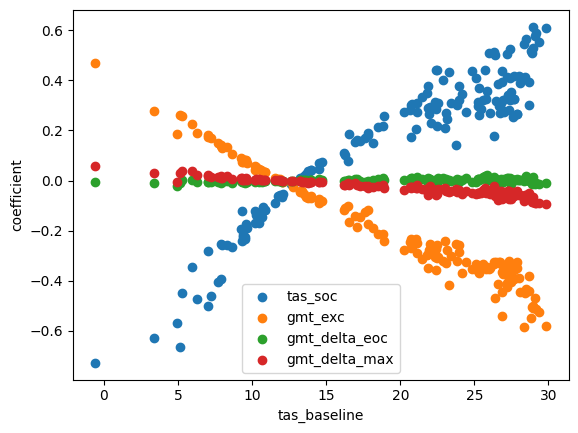

In [23]:
predictor_sets = [['tas_soc', 'gmt_cum', 'gmt_eoc'],
                  ['tas_soc', 'log_gmt_cum', 'gmt_eoc'],
                  ['tas_soc', 'gmt_max', 'gmt_eoc'],
                  ['tas_soc', 'gmt_max', 'gmt_cum', 'gmt_eoc'],
                   ['tas_soc', 'gmt_max', 'gmt_cum', 'gmt_eoc', 'gmt_soc']
                  ]

predictor_sets = [['tas_soc', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max']
                  ]

for sel_predictors in predictor_sets:
    coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
    tas_baselines    = []
    gdp_baselines    = []
    i_iso = 0 
    for iso in np.unique(regression_df['iso']): 
        # subset data for the country 
        country_data  = regression_df[regression_df['iso'] == iso]
        y_country     = np.log(country_data['diff_SSP2'].values)
        X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
        X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
        # X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
        coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
        tas_baselines.append(np.mean(country_data['tas_baseline']))
        gdp_baselines.append(np.mean(country_data['GDP_baseline']))
        i_iso += 1
    
    plt.figure()
    for i_pred in range(len(sel_predictors)):
        plt.scatter(tas_baselines, coefficients[:, i_pred], label = sel_predictors[i_pred])
        plt.xlabel('tas_baseline')
        plt.ylabel('coefficient')
    plt.legend()
    plt.show()